CIFAR-100 CNN 訓練系統
計算智慧期末專案

學生：李泓斌
學號：C111110141
任課教授：曾建誠

訓練成果：78.44% 驗證準確率

In [1]:
#!/usr/bin/env python3
"""
CIFAR-100 CNN Training System
Production-ready implementation with focus on performance and maintainability
"""

import os
import sys
import time
import json
import warnings
from dataclasses import dataclass, asdict
from typing import Dict, Tuple, Optional, List
from pathlib import Path
import logging
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR100

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

In [2]:
# =============================================================================
# System Configuration and Environment Check
# =============================================================================

class SystemChecker:
    """System environment verification and GPU configuration"""

    @staticmethod
    def check_environment() -> Dict[str, any]:
        """Verify system capabilities and return configuration"""
        config = {
            'cuda_available': torch.cuda.is_available(),
            'cuda_version': torch.version.cuda if torch.cuda.is_available() else None,
            'pytorch_version': torch.__version__,
            'device_count': torch.cuda.device_count() if torch.cuda.is_available() else 0,
            'device_name': torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU',
            'total_memory': torch.cuda.get_device_properties(0).total_memory // (1024**3) if torch.cuda.is_available() else 0
        }

        # Memory optimization settings
        if config['cuda_available']:
            torch.backends.cudnn.benchmark = True
            torch.backends.cuda.matmul.allow_tf32 = True
            torch.backends.cudnn.allow_tf32 = True

        return config

    @staticmethod
    def get_optimal_workers() -> int:
        """Determine optimal number of data loader workers"""
        try:
            import multiprocessing
            return min(4, multiprocessing.cpu_count())
        except:
            return 0  # Fallback for Colab environment

In [3]:
# =============================================================================
# Configuration Management
# =============================================================================

@dataclass
class TrainingConfig:
    """Training configuration with sensible defaults"""
    # Model parameters
    num_classes: int = 100
    input_channels: int = 3
    image_size: int = 32

    # Training parameters
    batch_size: int = 128
    epochs: int = 100
    learning_rate: float = 0.1
    momentum: float = 0.9
    weight_decay: float = 5e-4

    # Optimization
    gradient_clip: float = 1.0
    mixed_precision: bool = True
    gradient_accumulation_steps: int = 1

    # Regularization
    dropout_rate: float = 0.3
    label_smoothing: float = 0.1

    # Learning rate schedule
    lr_scheduler: str = 'cosine'  # 'cosine' or 'step'
    lr_milestones: List[int] = None
    lr_gamma: float = 0.1
    warmup_epochs: int = 5

    # Early stopping
    patience: int = 15
    min_delta: float = 0.001

    # Data augmentation
    augmentation_strength: str = 'moderate'  # 'light', 'moderate', 'strong'

    # System
    num_workers: int = 4
    pin_memory: bool = True
    checkpoint_interval: int = 5

    def __post_init__(self):
        if self.lr_milestones is None:
            self.lr_milestones = [30, 60, 80]

        # Adjust batch size based on available GPU memory
        if torch.cuda.is_available():
            gpu_memory = torch.cuda.get_device_properties(0).total_memory // (1024**3)
            if gpu_memory < 8:
                self.batch_size = min(self.batch_size, 64)
                print(f"Adjusted batch size to {self.batch_size} based on GPU memory")

In [4]:
# =============================================================================
# Data Pipeline
# =============================================================================

class CIFAR100DataModule:
    """Efficient data loading and augmentation pipeline"""

    def __init__(self, config: TrainingConfig):
        self.config = config
        self.mean = (0.5071, 0.4867, 0.4408)
        self.std = (0.2675, 0.2565, 0.2761)

    def get_transforms(self, train: bool = True) -> transforms.Compose:
        """Get data transformation pipeline"""
        if train:
            augmentation_configs = {
                'light': {
                    'rotation': 5,
                    'translate': (0.05, 0.05),
                    'scale': (0.95, 1.05)
                },
                'moderate': {
                    'rotation': 10,
                    'translate': (0.1, 0.1),
                    'scale': (0.9, 1.1)
                },
                'strong': {
                    'rotation': 15,
                    'translate': (0.15, 0.15),
                    'scale': (0.85, 1.15)
                }
            }

            aug_config = augmentation_configs[self.config.augmentation_strength]

            transform_list = [
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomAffine(
                    degrees=aug_config['rotation'],
                    translate=aug_config['translate'],
                    scale=aug_config['scale']
                ),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                transforms.ToTensor(),
                transforms.Normalize(self.mean, self.std),
            ]

            # Add Cutout augmentation for strong augmentation
            if self.config.augmentation_strength == 'strong':
                transform_list.append(CutoutTransform(n_holes=1, length=8))
        else:
            transform_list = [
                transforms.ToTensor(),
                transforms.Normalize(self.mean, self.std),
            ]

        return transforms.Compose(transform_list)

    def get_dataloaders(self) -> Tuple[DataLoader, DataLoader]:
        """Create training and validation dataloaders"""
        train_transform = self.get_transforms(train=True)
        val_transform = self.get_transforms(train=False)

        train_dataset = CIFAR100(
            root='./data',
            train=True,
            download=True,
            transform=train_transform
        )

        val_dataset = CIFAR100(
            root='./data',
            train=False,
            download=True,
            transform=val_transform
        )

        train_loader = DataLoader(
            train_dataset,
            batch_size=self.config.batch_size,
            shuffle=True,
            num_workers=self.config.num_workers,
            pin_memory=self.config.pin_memory,
            persistent_workers=self.config.num_workers > 0,
            prefetch_factor=2 if self.config.num_workers > 0 else None
        )

        val_loader = DataLoader(
            val_dataset,
            batch_size=self.config.batch_size * 2,  # Larger batch for validation
            shuffle=False,
            num_workers=self.config.num_workers,
            pin_memory=self.config.pin_memory,
            persistent_workers=self.config.num_workers > 0,
            prefetch_factor=2 if self.config.num_workers > 0 else None
        )

        return train_loader, val_loader

class CutoutTransform:
    """Cutout augmentation for improved regularization"""

    def __init__(self, n_holes: int = 1, length: int = 8):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h, w = img.size(1), img.size(2)
        mask = torch.ones((h, w), dtype=torch.float32)

        for _ in range(self.n_holes):
            y = torch.randint(high=h, size=(1,)).item()
            x = torch.randint(high=w, size=(1,)).item()

            y1 = max(0, y - self.length // 2)
            y2 = min(h, y + self.length // 2)
            x1 = max(0, x - self.length // 2)
            x2 = min(w, x + self.length // 2)

            mask[y1:y2, x1:x2] = 0.

        mask = mask.expand_as(img)
        img = img * mask
        return img

In [5]:
# =============================================================================
# Model Architecture
# =============================================================================

class ResidualBlock(nn.Module):
    """Efficient residual block with batch normalization"""

    def __init__(self, in_channels: int, out_channels: int, stride: int = 1, dropout_rate: float = 0.0):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout2d(dropout_rate) if dropout_rate > 0 else nn.Identity()

        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class CIFAR100CNN(nn.Module):
    """
    Efficient CNN for CIFAR-100 classification
    Architecture: Conv blocks with residual connections -> Global pooling -> FC
    """

    def __init__(self, config: TrainingConfig):
        super().__init__()
        self.config = config

        # Initial convolution
        self.conv1 = nn.Conv2d(3, 64, 3, 1, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        # Residual blocks with increasing channels
        self.layer1 = self._make_layer(64, 128, 2, stride=1)
        self.layer2 = self._make_layer(128, 256, 2, stride=2)
        self.layer3 = self._make_layer(256, 512, 2, stride=2)

        # Global average pooling and classifier
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(config.dropout_rate)
        self.fc = nn.Linear(512, config.num_classes)

        # Weight initialization
        self._initialize_weights()

    def _make_layer(self, in_channels: int, out_channels: int, num_blocks: int, stride: int):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride, self.config.dropout_rate))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels, 1, self.config.dropout_rate))
        return nn.Sequential(*layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.global_pool(out)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.fc(out)
        return out

    def get_model_stats(self) -> Dict[str, int]:
        """Calculate model complexity statistics"""
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)

        # Estimate FLOPs for 32x32 input
        def count_conv2d_flops(module):
            # FLOPs = 2 * input_channels * output_channels * kernel_h * kernel_w * output_h * output_w
            return 2 * module.in_channels * module.out_channels * \
                   module.kernel_size[0] * module.kernel_size[1] * \
                   (32 // module.stride[0]) * (32 // module.stride[0])

        total_flops = 0
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                total_flops += count_conv2d_flops(m)

        return {
            'total_params': total_params,
            'trainable_params': trainable_params,
            'total_params_mb': total_params * 4 / (1024 * 1024),  # Assuming float32
            'estimated_flops_m': total_flops / 1e6
        }

In [6]:
# =============================================================================
# Training Components
# =============================================================================

class LabelSmoothingCrossEntropy(nn.Module):
    """Label smoothing for better generalization"""

    def __init__(self, smoothing: float = 0.1):
        super().__init__()
        self.smoothing = smoothing
        self.confidence = 1.0 - smoothing

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=-1)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (pred.size(-1) - 1))
            true_dist.scatter_(1, target.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=-1))

class EarlyStopping:
    """Early stopping to prevent overfitting"""

    def __init__(self, patience: int = 10, min_delta: float = 0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

        return self.early_stop

class MetricTracker:
    """Track and analyze training metrics"""

    def __init__(self):
        self.metrics = defaultdict(list)
        self.current_epoch = 0

    def update(self, metric_dict: Dict[str, float], epoch: int = None):
        if epoch is not None:
            self.current_epoch = epoch

        for key, value in metric_dict.items():
            self.metrics[key].append(value)

    def get_best(self, metric: str, mode: str = 'max') -> Tuple[float, int]:
        """Get best value and epoch for a metric"""
        values = self.metrics[metric]
        if not values:
            return None, None

        if mode == 'max':
            best_idx = np.argmax(values)
        else:
            best_idx = np.argmin(values)

        return values[best_idx], best_idx

    def plot_metrics(self, save_path: Optional[str] = None):
        """Plot training curves"""
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))

        # Loss curves
        axes[0, 0].plot(self.metrics['train_loss'], label='Train Loss')
        axes[0, 0].plot(self.metrics['val_loss'], label='Val Loss')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].set_title('Loss Curves')
        axes[0, 0].legend()
        axes[0, 0].grid(True)

        # Accuracy curves
        axes[0, 1].plot(self.metrics['train_acc'], label='Train Acc')
        axes[0, 1].plot(self.metrics['val_acc'], label='Val Acc')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Accuracy (%)')
        axes[0, 1].set_title('Accuracy Curves')
        axes[0, 1].legend()
        axes[0, 1].grid(True)

        # Learning rate
        axes[1, 0].plot(self.metrics['learning_rate'])
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Learning Rate')
        axes[1, 0].set_title('Learning Rate Schedule')
        axes[1, 0].set_yscale('log')
        axes[1, 0].grid(True)

        # Top-5 Accuracy
        if 'val_acc_top5' in self.metrics:
            axes[1, 1].plot(self.metrics['val_acc_top5'], label='Val Top-5')
            axes[1, 1].set_xlabel('Epoch')
            axes[1, 1].set_ylabel('Top-5 Accuracy (%)')
            axes[1, 1].set_title('Top-5 Accuracy')
            axes[1, 1].legend()
            axes[1, 1].grid(True)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=100, bbox_inches='tight')
        plt.show()

In [7]:
# =============================================================================
# Training Engine
# =============================================================================

class Trainer:
    """Main training orchestrator with optimizations"""

    def __init__(self, model: nn.Module, config: TrainingConfig, device: torch.device):
        self.model = model
        self.config = config
        self.device = device

        # Move model to device
        self.model = self.model.to(device)

        # Loss function
        if config.label_smoothing > 0:
            self.criterion = LabelSmoothingCrossEntropy(config.label_smoothing)
        else:
            self.criterion = nn.CrossEntropyLoss()

        # Optimizer
        self.optimizer = optim.SGD(
            self.model.parameters(),
            lr=config.learning_rate,
            momentum=config.momentum,
            weight_decay=config.weight_decay,
            nesterov=True
        )

        # Learning rate scheduler
        if config.lr_scheduler == 'cosine':
            self.scheduler = optim.lr_scheduler.CosineAnnealingLR(
                self.optimizer,
                T_max=config.epochs
            )
        else:
            self.scheduler = optim.lr_scheduler.MultiStepLR(
                self.optimizer,
                milestones=config.lr_milestones,
                gamma=config.lr_gamma
            )

        # Mixed precision training
        self.scaler = GradScaler() if config.mixed_precision else None

        # Metrics and tracking
        self.metric_tracker = MetricTracker()
        self.early_stopping = EarlyStopping(config.patience, config.min_delta)

        # Best model tracking
        self.best_val_acc = 0.0
        self.best_model_state = None

    def train_epoch(self, train_loader: DataLoader, epoch: int) -> Dict[str, float]:
        """Train for one epoch"""
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Progress bar
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{self.config.epochs} [Train]')

        for batch_idx, (inputs, targets) in enumerate(pbar):
            inputs, targets = inputs.to(self.device), targets.to(self.device)

            # Mixed precision training
            if self.config.mixed_precision:
                with autocast():
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, targets)
                    loss = loss / self.config.gradient_accumulation_steps

                self.scaler.scale(loss).backward()

                if (batch_idx + 1) % self.config.gradient_accumulation_steps == 0:
                    # Gradient clipping
                    self.scaler.unscale_(self.optimizer)
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.config.gradient_clip)

                    self.scaler.step(self.optimizer)
                    self.scaler.update()
                    self.optimizer.zero_grad()
            else:
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                loss = loss / self.config.gradient_accumulation_steps
                loss.backward()

                if (batch_idx + 1) % self.config.gradient_accumulation_steps == 0:
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.config.gradient_clip)
                    self.optimizer.step()
                    self.optimizer.zero_grad()

            # Metrics
            running_loss += loss.item() * self.config.gradient_accumulation_steps
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            # Update progress bar
            current_acc = 100. * correct / total
            pbar.set_postfix({
                'loss': f'{running_loss/(batch_idx+1):.4f}',
                'acc': f'{current_acc:.2f}%'
            })

        return {
            'train_loss': running_loss / len(train_loader),
            'train_acc': 100. * correct / total
        }

    def validate(self, val_loader: DataLoader, epoch: int) -> Dict[str, float]:
        """Validate the model"""
        self.model.eval()
        running_loss = 0.0
        correct = 0
        correct_top5 = 0
        total = 0

        with torch.no_grad():
            pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{self.config.epochs} [Val]')

            for inputs, targets in pbar:
                inputs, targets = inputs.to(self.device), targets.to(self.device)

                if self.config.mixed_precision:
                    with autocast():
                        outputs = self.model(inputs)
                        loss = self.criterion(outputs, targets)
                else:
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, targets)

                running_loss += loss.item()

                # Top-1 accuracy
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

                # Top-5 accuracy
                _, pred_top5 = outputs.topk(5, 1, True, True)
                correct_top5 += pred_top5.eq(targets.view(-1, 1).expand_as(pred_top5)).sum().item()

                # Update progress bar
                current_acc = 100. * correct / total
                pbar.set_postfix({
                    'loss': f'{running_loss/(pbar.n+1):.4f}',
                    'acc': f'{current_acc:.2f}%'
                })

        return {
            'val_loss': running_loss / len(val_loader),
            'val_acc': 100. * correct / total,
            'val_acc_top5': 100. * correct_top5 / total
        }

    def train(self, train_loader: DataLoader, val_loader: DataLoader):
        """Full training loop"""
        print(f"\nStarting training on {self.device}")
        print(f"Model architecture: {self.model.__class__.__name__}")

        # Model statistics
        stats = self.model.get_model_stats()
        print(f"Total parameters: {stats['total_params']:,}")
        print(f"Trainable parameters: {stats['trainable_params']:,}")
        print(f"Model size: {stats['total_params_mb']:.2f} MB")
        print(f"Estimated FLOPs: {stats['estimated_flops_m']:.2f}M")
        print("-" * 50)

        start_time = time.time()

        for epoch in range(self.config.epochs):
            epoch_start = time.time()

            # Training
            train_metrics = self.train_epoch(train_loader, epoch)

            # Validation
            val_metrics = self.validate(val_loader, epoch)

            # Learning rate scheduling
            current_lr = self.optimizer.param_groups[0]['lr']
            self.scheduler.step()

            # Warm-up learning rate
            if epoch < self.config.warmup_epochs:
                warmup_lr = self.config.learning_rate * (epoch + 1) / self.config.warmup_epochs
                for param_group in self.optimizer.param_groups:
                    param_group['lr'] = warmup_lr
                current_lr = warmup_lr

            # Track metrics
            self.metric_tracker.update({
                **train_metrics,
                **val_metrics,
                'learning_rate': current_lr
            }, epoch)

            # Print epoch summary
            epoch_time = time.time() - epoch_start
            print(f"\nEpoch {epoch+1}/{self.config.epochs} - {epoch_time:.1f}s")
            print(f"Train Loss: {train_metrics['train_loss']:.4f}, Train Acc: {train_metrics['train_acc']:.2f}%")
            print(f"Val Loss: {val_metrics['val_loss']:.4f}, Val Acc: {val_metrics['val_acc']:.2f}%, Top-5: {val_metrics['val_acc_top5']:.2f}%")
            print(f"Learning Rate: {current_lr:.6f}")

            # Save best model
            if val_metrics['val_acc'] > self.best_val_acc:
                self.best_val_acc = val_metrics['val_acc']
                self.best_model_state = self.model.state_dict().copy()
                print(f"New best model! Val Acc: {self.best_val_acc:.2f}%")

            # Checkpoint
            if (epoch + 1) % self.config.checkpoint_interval == 0:
                self.save_checkpoint(epoch, val_metrics['val_acc'])

            # Early stopping
            if self.early_stopping(val_metrics['val_loss']):
                print(f"\nEarly stopping triggered at epoch {epoch+1}")
                break

            # Memory cleanup
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        total_time = time.time() - start_time
        print(f"\nTraining completed in {total_time/60:.1f} minutes")
        print(f"Best validation accuracy: {self.best_val_acc:.2f}%")

        # Load best model
        if self.best_model_state is not None:
            self.model.load_state_dict(self.best_model_state)

        return self.metric_tracker

    def save_checkpoint(self, epoch: int, val_acc: float):
        """Save model checkpoint"""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'val_acc': val_acc,
            'config': asdict(self.config)
        }

        checkpoint_path = f'checkpoint_epoch_{epoch+1}_acc_{val_acc:.2f}.pth'
        torch.save(checkpoint, checkpoint_path)
        print(f"Checkpoint saved: {checkpoint_path}")

    def test_model(self, test_loader: DataLoader) -> Dict[str, float]:
        """Final model evaluation"""
        self.model.eval()
        correct = 0
        correct_top5 = 0
        total = 0
        class_correct = list(0. for i in range(self.config.num_classes))
        class_total = list(0. for i in range(self.config.num_classes))

        with torch.no_grad():
            for inputs, targets in tqdm(test_loader, desc='Testing'):
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)

                # Top-1
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

                # Top-5
                _, pred_top5 = outputs.topk(5, 1, True, True)
                correct_top5 += pred_top5.eq(targets.view(-1, 1).expand_as(pred_top5)).sum().item()

                # Per-class accuracy
                c = predicted.eq(targets).squeeze()
                for i in range(targets.size(0)):
                    label = targets[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1

        # Calculate metrics
        test_acc = 100. * correct / total
        test_acc_top5 = 100. * correct_top5 / total

        print(f"\nTest Results:")
        print(f"Top-1 Accuracy: {test_acc:.2f}%")
        print(f"Top-5 Accuracy: {test_acc_top5:.2f}%")

        # Per-class accuracy analysis
        class_accuracies = []
        for i in range(self.config.num_classes):
            if class_total[i] > 0:
                acc = 100 * class_correct[i] / class_total[i]
                class_accuracies.append(acc)

        print(f"Mean class accuracy: {np.mean(class_accuracies):.2f}%")
        print(f"Std class accuracy: {np.std(class_accuracies):.2f}%")
        print(f"Min class accuracy: {np.min(class_accuracies):.2f}%")
        print(f"Max class accuracy: {np.max(class_accuracies):.2f}%")

        return {
            'test_acc': test_acc,
            'test_acc_top5': test_acc_top5,
            'class_accuracies': class_accuracies
        }

In [8]:
# =============================================================================
# Performance Monitoring
# =============================================================================

class PerformanceMonitor:
    """Monitor GPU usage and training performance"""

    def __init__(self):
        self.gpu_available = torch.cuda.is_available()

    def get_gpu_memory_usage(self) -> Dict[str, float]:
        """Get current GPU memory statistics"""
        if not self.gpu_available:
            return {}

        allocated = torch.cuda.memory_allocated() / 1024**3
        reserved = torch.cuda.memory_reserved() / 1024**3
        max_allocated = torch.cuda.max_memory_allocated() / 1024**3

        return {
            'allocated_gb': allocated,
            'reserved_gb': reserved,
            'max_allocated_gb': max_allocated,
            'free_gb': reserved - allocated
        }

    def profile_dataloader(self, dataloader: DataLoader, num_batches: int = 10) -> Dict[str, float]:
        """Profile data loading performance"""
        load_times = []

        for i, (data, target) in enumerate(dataloader):
            if i >= num_batches:
                break

            start = time.time()
            data = data.cuda(non_blocking=True) if self.gpu_available else data
            target = target.cuda(non_blocking=True) if self.gpu_available else target
            torch.cuda.synchronize() if self.gpu_available else None
            load_times.append(time.time() - start)

        return {
            'mean_load_time': np.mean(load_times),
            'std_load_time': np.std(load_times),
            'min_load_time': np.min(load_times),
            'max_load_time': np.max(load_times)
        }

    def benchmark_model(self, model: nn.Module, input_size: Tuple[int, ...],
                       batch_sizes: List[int] = [16, 32, 64, 128]) -> Dict[int, Dict[str, float]]:
        """Benchmark model inference speed"""
        model.eval()
        results = {}

        for batch_size in batch_sizes:
            try:
                dummy_input = torch.randn(batch_size, *input_size)
                if self.gpu_available:
                    dummy_input = dummy_input.cuda()
                    model = model.cuda()

                # Warm-up
                for _ in range(10):
                    with torch.no_grad():
                        _ = model(dummy_input)

                if self.gpu_available:
                    torch.cuda.synchronize()

                # Benchmark
                times = []
                for _ in range(100):
                    start = time.time()
                    with torch.no_grad():
                        _ = model(dummy_input)
                    if self.gpu_available:
                        torch.cuda.synchronize()
                    times.append(time.time() - start)

                results[batch_size] = {
                    'mean_time': np.mean(times),
                    'std_time': np.std(times),
                    'throughput': batch_size / np.mean(times),
                    'memory_gb': self.get_gpu_memory_usage().get('allocated_gb', 0)
                }

                # Clear cache
                if self.gpu_available:
                    torch.cuda.empty_cache()

            except RuntimeError as e:
                if 'out of memory' in str(e):
                    results[batch_size] = {'error': 'OOM'}
                    if self.gpu_available:
                        torch.cuda.empty_cache()
                else:
                    raise e

        return results

In [9]:
# =============================================================================
# Main Execution Pipeline
# =============================================================================

class CIFAR100Pipeline:
    """Complete training pipeline orchestrator"""

    def __init__(self, config: Optional[TrainingConfig] = None):
        self.config = config or TrainingConfig()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # System check
        self.system_info = SystemChecker.check_environment()
        self._print_system_info()

        # Adjust configuration based on system
        if self.system_info['cuda_available']:
            self.config.num_workers = SystemChecker.get_optimal_workers()
        else:
            self.config.mixed_precision = False
            self.config.num_workers = 0
            print("Warning: CUDA not available, falling back to CPU training")

    def _print_system_info(self):
        """Print system configuration"""
        print("="*50)
        print("System Configuration")
        print("="*50)
        for key, value in self.system_info.items():
            print(f"{key}: {value}")
        print("="*50)

    def run(self):
        """Execute complete training pipeline"""
        # Initialize components
        print("\nInitializing data pipeline...")
        data_module = CIFAR100DataModule(self.config)
        train_loader, val_loader = data_module.get_dataloaders()

        print(f"Training samples: {len(train_loader.dataset)}")
        print(f"Validation samples: {len(val_loader.dataset)}")

        # Initialize model
        print("\nInitializing model...")
        model = CIFAR100CNN(self.config)

        # Performance monitoring
        monitor = PerformanceMonitor()

        # Profile data loading
        print("\nProfiling data loader...")
        loader_stats = monitor.profile_dataloader(train_loader, num_batches=10)
        print(f"Mean batch load time: {loader_stats['mean_load_time']*1000:.2f}ms")

        # Benchmark model
        print("\nBenchmarking model performance...")
        benchmark_results = monitor.benchmark_model(
            model,
            input_size=(3, 32, 32),
            batch_sizes=[32, 64, 128, 256]
        )

        print("\nInference Benchmark Results:")
        print("-"*50)
        for batch_size, stats in benchmark_results.items():
            if 'error' in stats:
                print(f"Batch {batch_size}: {stats['error']}")
            else:
                print(f"Batch {batch_size}: {stats['throughput']:.1f} img/s, "
                      f"Memory: {stats['memory_gb']:.2f}GB")
        print("-"*50)

        # Initialize trainer
        print("\nInitializing trainer...")
        trainer = Trainer(model, self.config, self.device)

        # Training
        print("\n" + "="*50)
        print("Starting Training")
        print("="*50)

        try:
            metric_tracker = trainer.train(train_loader, val_loader)

            # Final evaluation
            print("\n" + "="*50)
            print("Final Evaluation")
            print("="*50)

            test_results = trainer.test_model(val_loader)

            # Plot training curves
            print("\nGenerating training curves...")
            metric_tracker.plot_metrics(save_path='training_curves.png')

            # Memory usage summary
            if monitor.gpu_available:
                mem_stats = monitor.get_gpu_memory_usage()
                print("\nGPU Memory Usage:")
                print(f"Peak allocated: {mem_stats['max_allocated_gb']:.2f}GB")
                print(f"Current allocated: {mem_stats['allocated_gb']:.2f}GB")

            # Training summary
            best_val_acc, best_epoch = metric_tracker.get_best('val_acc', mode='max')
            print("\n" + "="*50)
            print("Training Summary")
            print("="*50)
            print(f"Best validation accuracy: {best_val_acc:.2f}% (Epoch {best_epoch+1})")
            print(f"Final test accuracy: {test_results['test_acc']:.2f}%")
            print(f"Final test top-5 accuracy: {test_results['test_acc_top5']:.2f}%")

            # Save final model
            self._save_final_model(trainer.model, test_results)

            return trainer.model, metric_tracker, test_results

        except KeyboardInterrupt:
            print("\nTraining interrupted by user")
            return trainer.model, trainer.metric_tracker, None
        except Exception as e:
            print(f"\nError during training: {str(e)}")
            raise e
        finally:
            # Cleanup
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    def _save_final_model(self, model: nn.Module, test_results: Dict):
        """Save the final trained model"""
        model_save_path = 'cifar100_final_model.pth'

        save_dict = {
            'model_state_dict': model.state_dict(),
            'config': asdict(self.config),
            'test_results': test_results,
            'model_stats': model.get_model_stats()
        }

        torch.save(save_dict, model_save_path)
        print(f"\nFinal model saved to: {model_save_path}")

In [10]:
# =============================================================================
# Quick Start Function
# =============================================================================

def train_cifar100(
    epochs: int = 100,
    batch_size: int = 128,
    learning_rate: float = 0.1,
    mixed_precision: bool = True,
    augmentation: str = 'moderate'
):
    """
    Quick start training function

    Args:
        epochs: Number of training epochs
        batch_size: Batch size for training
        learning_rate: Initial learning rate
        mixed_precision: Use mixed precision training
        augmentation: Data augmentation strength ('light', 'moderate', 'strong')

    Returns:
        Trained model, metrics tracker, and test results
    """
    config = TrainingConfig(
        epochs=epochs,
        batch_size=batch_size,
        learning_rate=learning_rate,
        mixed_precision=mixed_precision,
        augmentation_strength=augmentation
    )

    pipeline = CIFAR100Pipeline(config)
    return pipeline.run()

Running in Google Colab environment
Mounted at /content/drive

CIFAR-100 CNN Training System
Production-Ready Implementation
System Configuration
cuda_available: True
cuda_version: 12.6
pytorch_version: 2.8.0+cu126
device_count: 1
device_name: Tesla T4
total_memory: 14

Initializing data pipeline...


100%|██████████| 169M/169M [00:13<00:00, 12.8MB/s]


Training samples: 50000
Validation samples: 10000

Initializing model...

Profiling data loader...
Mean batch load time: 0.76ms

Benchmarking model performance...

Inference Benchmark Results:
--------------------------------------------------
Batch 32: 2086.6 img/s, Memory: 0.05GB
Batch 64: 2167.9 img/s, Memory: 0.05GB
Batch 128: 2224.1 img/s, Memory: 0.05GB
Batch 256: 2211.3 img/s, Memory: 0.05GB
--------------------------------------------------

Initializing trainer...

Starting Training

Starting training on cuda
Model architecture: CIFAR100CNN
Total parameters: 11,072,164
Trainable parameters: 11,072,164
Model size: 42.24 MB
Estimated FLOPs: 20035.53M
--------------------------------------------------


Epoch 1/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 1/150 - 87.0s
Train Loss: 4.3294, Train Acc: 5.00%
Val Loss: 4.0752, Val Acc: 8.75%, Top-5: 27.88%
Learning Rate: 0.030000
New best model! Val Acc: 8.75%


Epoch 2/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 2/150 - 58.4s
Train Loss: 4.0406, Train Acc: 9.23%
Val Loss: 3.8752, Val Acc: 12.96%, Top-5: 36.79%
Learning Rate: 0.060000
New best model! Val Acc: 12.96%


Epoch 3/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 3/150 - 57.1s
Train Loss: 3.9715, Train Acc: 10.69%
Val Loss: 3.7844, Val Acc: 15.22%, Top-5: 39.99%
Learning Rate: 0.090000
New best model! Val Acc: 15.22%


Epoch 4/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 4/150 - 57.2s
Train Loss: 3.8674, Train Acc: 12.97%
Val Loss: 3.6534, Val Acc: 17.65%, Top-5: 45.77%
Learning Rate: 0.120000
New best model! Val Acc: 17.65%


Epoch 5/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 5/150 - 58.4s
Train Loss: 3.7566, Train Acc: 15.59%
Val Loss: 3.5135, Val Acc: 20.65%, Top-5: 50.55%
Learning Rate: 0.150000
New best model! Val Acc: 20.65%
Checkpoint saved: checkpoint_epoch_5_acc_20.65.pth


Epoch 6/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 6/150 - 56.9s
Train Loss: 3.6258, Train Acc: 18.29%
Val Loss: 3.3488, Val Acc: 24.76%, Top-5: 55.61%
Learning Rate: 0.150000
New best model! Val Acc: 24.76%


Epoch 7/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 7/150 - 57.4s
Train Loss: 3.4813, Train Acc: 21.39%
Val Loss: 3.2045, Val Acc: 28.92%, Top-5: 59.30%
Learning Rate: 0.149819
New best model! Val Acc: 28.92%


Epoch 8/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 8/150 - 57.7s
Train Loss: 3.3511, Train Acc: 24.61%
Val Loss: 3.0352, Val Acc: 31.62%, Top-5: 64.43%
Learning Rate: 0.149605
New best model! Val Acc: 31.62%


Epoch 9/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 9/150 - 59.5s
Train Loss: 3.2394, Train Acc: 27.33%
Val Loss: 2.9852, Val Acc: 33.59%, Top-5: 66.28%
Learning Rate: 0.149359
New best model! Val Acc: 33.59%


Epoch 10/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 10/150 - 57.7s
Train Loss: 3.1287, Train Acc: 30.35%
Val Loss: 2.8766, Val Acc: 37.09%, Top-5: 70.32%
Learning Rate: 0.149080
New best model! Val Acc: 37.09%
Checkpoint saved: checkpoint_epoch_10_acc_37.09.pth


Epoch 11/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 11/150 - 59.1s
Train Loss: 3.0414, Train Acc: 32.81%
Val Loss: 2.7581, Val Acc: 39.94%, Top-5: 72.74%
Learning Rate: 0.148769
New best model! Val Acc: 39.94%


Epoch 12/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 12/150 - 59.7s
Train Loss: 2.9585, Train Acc: 35.05%
Val Loss: 2.7603, Val Acc: 40.14%, Top-5: 72.88%
Learning Rate: 0.148425
New best model! Val Acc: 40.14%


Epoch 13/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 13/150 - 58.4s
Train Loss: 2.8913, Train Acc: 36.65%
Val Loss: 2.6624, Val Acc: 43.40%, Top-5: 74.99%
Learning Rate: 0.148049
New best model! Val Acc: 43.40%


Epoch 14/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 14/150 - 59.2s
Train Loss: 2.8316, Train Acc: 38.27%
Val Loss: 2.6019, Val Acc: 45.09%, Top-5: 75.93%
Learning Rate: 0.147642
New best model! Val Acc: 45.09%


Epoch 15/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 15/150 - 59.8s
Train Loss: 2.7754, Train Acc: 40.18%
Val Loss: 2.5643, Val Acc: 46.58%, Top-5: 76.88%
Learning Rate: 0.147202
New best model! Val Acc: 46.58%
Checkpoint saved: checkpoint_epoch_15_acc_46.58.pth


Epoch 16/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 16/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 16/150 - 57.3s
Train Loss: 2.7460, Train Acc: 40.87%
Val Loss: 2.5425, Val Acc: 46.42%, Top-5: 78.00%
Learning Rate: 0.146731


Epoch 17/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 17/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 17/150 - 58.1s
Train Loss: 2.7120, Train Acc: 41.95%
Val Loss: 2.4994, Val Acc: 48.64%, Top-5: 79.05%
Learning Rate: 0.146229
New best model! Val Acc: 48.64%


Epoch 18/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 18/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 18/150 - 59.7s
Train Loss: 2.6775, Train Acc: 43.14%
Val Loss: 2.4099, Val Acc: 50.66%, Top-5: 80.86%
Learning Rate: 0.145695
New best model! Val Acc: 50.66%


Epoch 19/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 19/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 19/150 - 57.7s
Train Loss: 2.6494, Train Acc: 44.05%
Val Loss: 2.4854, Val Acc: 49.40%, Top-5: 79.13%
Learning Rate: 0.145131


Epoch 20/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 20/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 20/150 - 58.6s
Train Loss: 2.6251, Train Acc: 44.50%
Val Loss: 2.4678, Val Acc: 49.86%, Top-5: 79.94%
Learning Rate: 0.144536
Checkpoint saved: checkpoint_epoch_20_acc_49.86.pth


Epoch 21/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 21/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 21/150 - 59.3s
Train Loss: 2.6039, Train Acc: 45.27%
Val Loss: 2.3528, Val Acc: 52.55%, Top-5: 82.97%
Learning Rate: 0.143910
New best model! Val Acc: 52.55%


Epoch 22/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 22/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 22/150 - 58.0s
Train Loss: 2.5874, Train Acc: 45.71%
Val Loss: 2.4314, Val Acc: 50.95%, Top-5: 80.84%
Learning Rate: 0.143254


Epoch 23/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 23/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 23/150 - 57.3s
Train Loss: 2.5693, Train Acc: 46.21%
Val Loss: 2.3229, Val Acc: 53.79%, Top-5: 82.87%
Learning Rate: 0.142569
New best model! Val Acc: 53.79%


Epoch 24/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 24/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 24/150 - 59.5s
Train Loss: 2.5576, Train Acc: 46.65%
Val Loss: 2.3127, Val Acc: 54.40%, Top-5: 83.22%
Learning Rate: 0.141854
New best model! Val Acc: 54.40%


Epoch 25/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 25/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 25/150 - 59.1s
Train Loss: 2.5415, Train Acc: 47.27%
Val Loss: 2.3919, Val Acc: 51.58%, Top-5: 80.92%
Learning Rate: 0.141110
Checkpoint saved: checkpoint_epoch_25_acc_51.58.pth


Epoch 26/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 26/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 26/150 - 58.6s
Train Loss: 2.5352, Train Acc: 47.04%
Val Loss: 2.3448, Val Acc: 53.88%, Top-5: 82.57%
Learning Rate: 0.140336


Epoch 27/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 27/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 27/150 - 58.4s
Train Loss: 2.5219, Train Acc: 47.79%
Val Loss: 2.3374, Val Acc: 53.98%, Top-5: 82.92%
Learning Rate: 0.139535


Epoch 28/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 28/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 28/150 - 60.1s
Train Loss: 2.5021, Train Acc: 48.47%
Val Loss: 2.3517, Val Acc: 53.51%, Top-5: 82.93%
Learning Rate: 0.138705


Epoch 29/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 29/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 29/150 - 58.5s
Train Loss: 2.4955, Train Acc: 48.61%
Val Loss: 2.2550, Val Acc: 56.51%, Top-5: 84.59%
Learning Rate: 0.137847
New best model! Val Acc: 56.51%


Epoch 30/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 30/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 30/150 - 58.3s
Train Loss: 2.4861, Train Acc: 48.96%
Val Loss: 2.3140, Val Acc: 54.62%, Top-5: 82.50%
Learning Rate: 0.136961
Checkpoint saved: checkpoint_epoch_30_acc_54.62.pth


Epoch 31/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 31/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 31/150 - 59.9s
Train Loss: 2.4742, Train Acc: 48.95%
Val Loss: 2.3084, Val Acc: 54.83%, Top-5: 83.26%
Learning Rate: 0.136049


Epoch 32/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 32/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 32/150 - 58.2s
Train Loss: 2.4734, Train Acc: 49.28%
Val Loss: 2.2522, Val Acc: 56.35%, Top-5: 84.80%
Learning Rate: 0.135110


Epoch 33/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 33/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 33/150 - 58.1s
Train Loss: 2.4505, Train Acc: 50.01%
Val Loss: 2.2836, Val Acc: 55.65%, Top-5: 84.30%
Learning Rate: 0.134144


Epoch 34/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 34/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 34/150 - 59.8s
Train Loss: 2.4491, Train Acc: 49.95%
Val Loss: 2.2391, Val Acc: 55.92%, Top-5: 84.00%
Learning Rate: 0.133153


Epoch 35/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 35/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 35/150 - 58.5s
Train Loss: 2.4372, Train Acc: 50.57%
Val Loss: 2.1876, Val Acc: 58.38%, Top-5: 85.96%
Learning Rate: 0.132137
New best model! Val Acc: 58.38%
Checkpoint saved: checkpoint_epoch_35_acc_58.38.pth


Epoch 36/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 36/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 36/150 - 58.5s
Train Loss: 2.4299, Train Acc: 50.52%
Val Loss: 2.3441, Val Acc: 53.53%, Top-5: 82.96%
Learning Rate: 0.131095


Epoch 37/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 37/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 37/150 - 59.4s
Train Loss: 2.4216, Train Acc: 50.75%
Val Loss: 2.2308, Val Acc: 56.76%, Top-5: 84.96%
Learning Rate: 0.130029


Epoch 38/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 38/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 38/150 - 57.8s
Train Loss: 2.4164, Train Acc: 50.99%
Val Loss: 2.1683, Val Acc: 58.78%, Top-5: 85.96%
Learning Rate: 0.128939
New best model! Val Acc: 58.78%


Epoch 39/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 39/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 39/150 - 58.4s
Train Loss: 2.4075, Train Acc: 51.31%
Val Loss: 2.2390, Val Acc: 56.74%, Top-5: 83.96%
Learning Rate: 0.127825


Epoch 40/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 40/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 40/150 - 59.0s
Train Loss: 2.4002, Train Acc: 51.34%
Val Loss: 2.1534, Val Acc: 59.20%, Top-5: 86.52%
Learning Rate: 0.126688
New best model! Val Acc: 59.20%
Checkpoint saved: checkpoint_epoch_40_acc_59.20.pth


Epoch 41/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 41/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 41/150 - 57.8s
Train Loss: 2.3926, Train Acc: 51.73%
Val Loss: 2.2021, Val Acc: 58.49%, Top-5: 85.56%
Learning Rate: 0.125529


Epoch 42/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 42/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 42/150 - 58.1s
Train Loss: 2.3860, Train Acc: 52.03%
Val Loss: 2.1562, Val Acc: 59.75%, Top-5: 86.22%
Learning Rate: 0.124347
New best model! Val Acc: 59.75%


Epoch 43/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 43/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 43/150 - 60.0s
Train Loss: 2.3848, Train Acc: 52.27%
Val Loss: 2.1723, Val Acc: 59.08%, Top-5: 85.47%
Learning Rate: 0.123144


Epoch 44/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 44/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 44/150 - 58.5s
Train Loss: 2.3855, Train Acc: 52.35%
Val Loss: 2.1485, Val Acc: 59.44%, Top-5: 86.12%
Learning Rate: 0.121920


Epoch 45/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 45/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 45/150 - 58.4s
Train Loss: 2.3649, Train Acc: 52.74%
Val Loss: 2.1582, Val Acc: 59.51%, Top-5: 86.08%
Learning Rate: 0.120675
Checkpoint saved: checkpoint_epoch_45_acc_59.51.pth


Epoch 46/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 46/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 46/150 - 59.0s
Train Loss: 2.3664, Train Acc: 52.81%
Val Loss: 2.1033, Val Acc: 60.73%, Top-5: 86.83%
Learning Rate: 0.119411
New best model! Val Acc: 60.73%


Epoch 47/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 47/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 47/150 - 58.0s
Train Loss: 2.3530, Train Acc: 52.88%
Val Loss: 2.1521, Val Acc: 59.43%, Top-5: 86.07%
Learning Rate: 0.118127


Epoch 48/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 48/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 48/150 - 57.6s
Train Loss: 2.3421, Train Acc: 53.36%
Val Loss: 2.1269, Val Acc: 60.56%, Top-5: 87.16%
Learning Rate: 0.116824


Epoch 49/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 49/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 49/150 - 59.7s
Train Loss: 2.3418, Train Acc: 53.43%
Val Loss: 2.1070, Val Acc: 60.74%, Top-5: 87.22%
Learning Rate: 0.115503
New best model! Val Acc: 60.74%


Epoch 50/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 50/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 50/150 - 58.1s
Train Loss: 2.3302, Train Acc: 53.85%
Val Loss: 2.0704, Val Acc: 61.42%, Top-5: 87.79%
Learning Rate: 0.114165
New best model! Val Acc: 61.42%
Checkpoint saved: checkpoint_epoch_50_acc_61.42.pth


Epoch 51/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 51/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 51/150 - 58.0s
Train Loss: 2.3315, Train Acc: 53.72%
Val Loss: 2.1266, Val Acc: 60.30%, Top-5: 87.75%
Learning Rate: 0.112809


Epoch 52/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 52/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 52/150 - 59.4s
Train Loss: 2.3278, Train Acc: 53.93%
Val Loss: 2.0776, Val Acc: 61.13%, Top-5: 87.71%
Learning Rate: 0.111437


Epoch 53/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 53/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 53/150 - 58.8s
Train Loss: 2.3145, Train Acc: 54.31%
Val Loss: 2.1231, Val Acc: 60.08%, Top-5: 86.93%
Learning Rate: 0.110049


Epoch 54/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 54/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 54/150 - 58.7s
Train Loss: 2.3106, Train Acc: 54.21%
Val Loss: 2.1442, Val Acc: 59.03%, Top-5: 86.84%
Learning Rate: 0.108645


Epoch 55/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 55/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 55/150 - 59.8s
Train Loss: 2.3011, Train Acc: 54.68%
Val Loss: 2.1041, Val Acc: 61.53%, Top-5: 87.04%
Learning Rate: 0.107227
New best model! Val Acc: 61.53%
Checkpoint saved: checkpoint_epoch_55_acc_61.53.pth


Epoch 56/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 56/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 56/150 - 58.7s
Train Loss: 2.3001, Train Acc: 54.87%
Val Loss: 2.1299, Val Acc: 60.18%, Top-5: 86.52%
Learning Rate: 0.105795


Epoch 57/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 57/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 57/150 - 58.5s
Train Loss: 2.2896, Train Acc: 55.11%
Val Loss: 2.1094, Val Acc: 61.29%, Top-5: 87.23%
Learning Rate: 0.104349


Epoch 58/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 58/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 58/150 - 59.1s
Train Loss: 2.2888, Train Acc: 55.21%
Val Loss: 2.0617, Val Acc: 62.06%, Top-5: 88.37%
Learning Rate: 0.102891
New best model! Val Acc: 62.06%


Epoch 59/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 59/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 59/150 - 60.2s
Train Loss: 2.2751, Train Acc: 55.79%
Val Loss: 2.0935, Val Acc: 61.58%, Top-5: 87.39%
Learning Rate: 0.101421


Epoch 60/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 60/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 60/150 - 58.1s
Train Loss: 2.2671, Train Acc: 55.88%
Val Loss: 2.0414, Val Acc: 63.06%, Top-5: 88.84%
Learning Rate: 0.099939
New best model! Val Acc: 63.06%
Checkpoint saved: checkpoint_epoch_60_acc_63.06.pth


Epoch 61/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 61/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 61/150 - 58.0s
Train Loss: 2.2603, Train Acc: 56.09%
Val Loss: 2.0707, Val Acc: 62.36%, Top-5: 88.03%
Learning Rate: 0.098446


Epoch 62/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 62/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 62/150 - 59.9s
Train Loss: 2.2571, Train Acc: 56.39%
Val Loss: 2.0498, Val Acc: 63.04%, Top-5: 87.95%
Learning Rate: 0.096943


Epoch 63/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 63/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 63/150 - 58.3s
Train Loss: 2.2501, Train Acc: 56.60%
Val Loss: 2.0542, Val Acc: 62.66%, Top-5: 87.72%
Learning Rate: 0.095430


Epoch 64/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 64/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 64/150 - 57.7s
Train Loss: 2.2416, Train Acc: 56.77%
Val Loss: 2.0268, Val Acc: 64.15%, Top-5: 88.96%
Learning Rate: 0.093909
New best model! Val Acc: 64.15%


Epoch 65/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 65/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 65/150 - 59.6s
Train Loss: 2.2377, Train Acc: 56.67%
Val Loss: 2.0428, Val Acc: 63.18%, Top-5: 88.07%
Learning Rate: 0.092379
Checkpoint saved: checkpoint_epoch_65_acc_63.18.pth


Epoch 66/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 66/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 66/150 - 57.7s
Train Loss: 2.2333, Train Acc: 57.15%
Val Loss: 2.0496, Val Acc: 62.51%, Top-5: 88.03%
Learning Rate: 0.090842


Epoch 67/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 67/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 67/150 - 57.5s
Train Loss: 2.2236, Train Acc: 57.12%
Val Loss: 2.0604, Val Acc: 62.97%, Top-5: 88.19%
Learning Rate: 0.089298


Epoch 68/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 68/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 68/150 - 59.1s
Train Loss: 2.2119, Train Acc: 57.57%
Val Loss: 1.9933, Val Acc: 64.36%, Top-5: 89.40%
Learning Rate: 0.087748
New best model! Val Acc: 64.36%


Epoch 69/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 69/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 69/150 - 58.0s
Train Loss: 2.2103, Train Acc: 57.58%
Val Loss: 2.0274, Val Acc: 62.84%, Top-5: 88.58%
Learning Rate: 0.086192


Epoch 70/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 70/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 70/150 - 58.6s
Train Loss: 2.1906, Train Acc: 58.30%
Val Loss: 1.9892, Val Acc: 64.25%, Top-5: 89.39%
Learning Rate: 0.084632
Checkpoint saved: checkpoint_epoch_70_acc_64.25.pth


Epoch 71/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 71/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 71/150 - 59.9s
Train Loss: 2.1844, Train Acc: 58.71%
Val Loss: 1.9765, Val Acc: 64.41%, Top-5: 89.41%
Learning Rate: 0.083067
New best model! Val Acc: 64.41%


Epoch 72/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 72/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 72/150 - 58.1s
Train Loss: 2.1840, Train Acc: 58.32%
Val Loss: 2.0228, Val Acc: 63.57%, Top-5: 88.61%
Learning Rate: 0.081499


Epoch 73/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 73/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 73/150 - 58.4s
Train Loss: 2.1712, Train Acc: 58.81%
Val Loss: 1.9265, Val Acc: 66.55%, Top-5: 90.94%
Learning Rate: 0.079928
New best model! Val Acc: 66.55%


Epoch 74/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 74/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 74/150 - 59.4s
Train Loss: 2.1756, Train Acc: 59.05%
Val Loss: 2.0123, Val Acc: 64.29%, Top-5: 88.88%
Learning Rate: 0.078355


Epoch 75/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 75/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 75/150 - 58.1s
Train Loss: 2.1632, Train Acc: 59.52%
Val Loss: 2.0135, Val Acc: 63.99%, Top-5: 88.54%
Learning Rate: 0.076781
Checkpoint saved: checkpoint_epoch_75_acc_63.99.pth


Epoch 76/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 76/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 76/150 - 59.7s
Train Loss: 2.1561, Train Acc: 59.65%
Val Loss: 2.0116, Val Acc: 64.15%, Top-5: 89.12%
Learning Rate: 0.075206


Epoch 77/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 77/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 77/150 - 58.6s
Train Loss: 2.1498, Train Acc: 59.74%
Val Loss: 2.0256, Val Acc: 63.43%, Top-5: 87.96%
Learning Rate: 0.073631


Epoch 78/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 78/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 78/150 - 58.1s
Train Loss: 2.1361, Train Acc: 60.05%
Val Loss: 1.9142, Val Acc: 66.62%, Top-5: 90.71%
Learning Rate: 0.072057
New best model! Val Acc: 66.62%


Epoch 79/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 79/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 79/150 - 58.9s
Train Loss: 2.1332, Train Acc: 60.26%
Val Loss: 1.9601, Val Acc: 65.49%, Top-5: 89.72%
Learning Rate: 0.070484


Epoch 80/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 80/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 80/150 - 58.8s
Train Loss: 2.1185, Train Acc: 60.68%
Val Loss: 1.9215, Val Acc: 67.01%, Top-5: 90.40%
Learning Rate: 0.068913
New best model! Val Acc: 67.01%
Checkpoint saved: checkpoint_epoch_80_acc_67.01.pth


Epoch 81/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 81/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 81/150 - 58.3s
Train Loss: 2.1063, Train Acc: 61.12%
Val Loss: 1.9274, Val Acc: 66.78%, Top-5: 89.82%
Learning Rate: 0.067345


Epoch 82/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 82/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 82/150 - 59.0s
Train Loss: 2.1042, Train Acc: 61.32%
Val Loss: 1.9155, Val Acc: 67.31%, Top-5: 90.35%
Learning Rate: 0.065780
New best model! Val Acc: 67.31%


Epoch 83/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 83/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 83/150 - 58.0s
Train Loss: 2.0981, Train Acc: 61.46%
Val Loss: 1.9080, Val Acc: 67.30%, Top-5: 90.37%
Learning Rate: 0.064220


Epoch 84/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 84/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 84/150 - 58.7s
Train Loss: 2.0913, Train Acc: 61.59%
Val Loss: 1.8779, Val Acc: 68.35%, Top-5: 91.21%
Learning Rate: 0.062664
New best model! Val Acc: 68.35%


Epoch 85/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 85/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 85/150 - 59.8s
Train Loss: 2.0795, Train Acc: 62.01%
Val Loss: 1.9422, Val Acc: 66.32%, Top-5: 90.33%
Learning Rate: 0.061114
Checkpoint saved: checkpoint_epoch_85_acc_66.32.pth


Epoch 86/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 86/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 86/150 - 59.3s
Train Loss: 2.0664, Train Acc: 62.19%
Val Loss: 1.9050, Val Acc: 67.30%, Top-5: 90.61%
Learning Rate: 0.059570


Epoch 87/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 87/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 87/150 - 59.0s
Train Loss: 2.0589, Train Acc: 62.76%
Val Loss: 1.9000, Val Acc: 67.69%, Top-5: 90.11%
Learning Rate: 0.058033


Epoch 88/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 88/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 88/150 - 62.5s
Train Loss: 2.0468, Train Acc: 63.13%
Val Loss: 1.8287, Val Acc: 70.16%, Top-5: 91.67%
Learning Rate: 0.056503
New best model! Val Acc: 70.16%


Epoch 89/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 89/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 89/150 - 59.0s
Train Loss: 2.0428, Train Acc: 63.21%
Val Loss: 1.8810, Val Acc: 68.01%, Top-5: 91.11%
Learning Rate: 0.054982


Epoch 90/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 90/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 90/150 - 59.8s
Train Loss: 2.0346, Train Acc: 63.50%
Val Loss: 1.8554, Val Acc: 68.87%, Top-5: 91.19%
Learning Rate: 0.053469
Checkpoint saved: checkpoint_epoch_90_acc_68.87.pth


Epoch 91/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 91/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 91/150 - 62.1s
Train Loss: 2.0153, Train Acc: 64.34%
Val Loss: 1.8731, Val Acc: 68.72%, Top-5: 90.94%
Learning Rate: 0.051966


Epoch 92/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 92/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 92/150 - 59.0s
Train Loss: 2.0157, Train Acc: 64.42%
Val Loss: 1.8340, Val Acc: 70.22%, Top-5: 92.03%
Learning Rate: 0.050473
New best model! Val Acc: 70.22%


Epoch 93/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 93/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 93/150 - 60.3s
Train Loss: 2.0012, Train Acc: 64.77%
Val Loss: 1.8405, Val Acc: 69.30%, Top-5: 91.74%
Learning Rate: 0.048991


Epoch 94/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 94/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 94/150 - 62.7s
Train Loss: 1.9953, Train Acc: 64.83%
Val Loss: 1.8145, Val Acc: 70.66%, Top-5: 92.01%
Learning Rate: 0.047521
New best model! Val Acc: 70.66%


Epoch 95/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 95/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 95/150 - 60.5s
Train Loss: 1.9870, Train Acc: 65.45%
Val Loss: 1.8135, Val Acc: 70.23%, Top-5: 92.18%
Learning Rate: 0.046062
Checkpoint saved: checkpoint_epoch_95_acc_70.23.pth


Epoch 96/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 96/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 96/150 - 60.2s
Train Loss: 1.9757, Train Acc: 65.52%
Val Loss: 1.8198, Val Acc: 70.69%, Top-5: 91.69%
Learning Rate: 0.044617
New best model! Val Acc: 70.69%


Epoch 97/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 97/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 97/150 - 61.2s
Train Loss: 1.9643, Train Acc: 65.96%
Val Loss: 1.8247, Val Acc: 70.16%, Top-5: 91.86%
Learning Rate: 0.043185


Epoch 98/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 98/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 98/150 - 60.3s
Train Loss: 1.9522, Train Acc: 66.31%
Val Loss: 1.8050, Val Acc: 71.39%, Top-5: 92.51%
Learning Rate: 0.041767
New best model! Val Acc: 71.39%


Epoch 99/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 99/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 99/150 - 62.1s
Train Loss: 1.9467, Train Acc: 66.58%
Val Loss: 1.7657, Val Acc: 72.21%, Top-5: 93.23%
Learning Rate: 0.040363
New best model! Val Acc: 72.21%


Epoch 100/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 100/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 100/150 - 61.7s
Train Loss: 1.9317, Train Acc: 67.06%
Val Loss: 1.7823, Val Acc: 71.89%, Top-5: 92.76%
Learning Rate: 0.038975
Checkpoint saved: checkpoint_epoch_100_acc_71.89.pth


Epoch 101/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 101/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 101/150 - 61.0s
Train Loss: 1.9231, Train Acc: 67.49%
Val Loss: 1.8202, Val Acc: 70.78%, Top-5: 92.38%
Learning Rate: 0.037603


Epoch 102/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 102/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 102/150 - 61.8s
Train Loss: 1.9100, Train Acc: 67.77%
Val Loss: 1.7808, Val Acc: 71.80%, Top-5: 92.40%
Learning Rate: 0.036247


Epoch 103/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 103/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 103/150 - 60.3s
Train Loss: 1.9040, Train Acc: 68.01%
Val Loss: 1.7956, Val Acc: 71.28%, Top-5: 92.45%
Learning Rate: 0.034909


Epoch 104/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 104/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 104/150 - 60.2s
Train Loss: 1.8883, Train Acc: 68.69%
Val Loss: 1.7829, Val Acc: 71.82%, Top-5: 92.49%
Learning Rate: 0.033588


Epoch 105/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 105/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 105/150 - 61.5s
Train Loss: 1.8763, Train Acc: 69.34%
Val Loss: 1.7442, Val Acc: 72.84%, Top-5: 92.55%
Learning Rate: 0.032285
New best model! Val Acc: 72.84%
Checkpoint saved: checkpoint_epoch_105_acc_72.84.pth


Epoch 106/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 106/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 106/150 - 61.3s
Train Loss: 1.8712, Train Acc: 69.51%
Val Loss: 1.7699, Val Acc: 71.84%, Top-5: 92.68%
Learning Rate: 0.031001


Epoch 107/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 107/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 107/150 - 61.3s
Train Loss: 1.8574, Train Acc: 69.90%
Val Loss: 1.7653, Val Acc: 72.32%, Top-5: 92.47%
Learning Rate: 0.029737


Epoch 108/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 108/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 108/150 - 61.1s
Train Loss: 1.8460, Train Acc: 69.99%
Val Loss: 1.7577, Val Acc: 72.18%, Top-5: 92.54%
Learning Rate: 0.028492


Epoch 109/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 109/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 109/150 - 60.8s
Train Loss: 1.8362, Train Acc: 70.55%
Val Loss: 1.7396, Val Acc: 73.25%, Top-5: 93.02%
Learning Rate: 0.027268
New best model! Val Acc: 73.25%


Epoch 110/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 110/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 110/150 - 61.8s
Train Loss: 1.8269, Train Acc: 70.77%
Val Loss: 1.7084, Val Acc: 74.08%, Top-5: 93.37%
Learning Rate: 0.026065
New best model! Val Acc: 74.08%
Checkpoint saved: checkpoint_epoch_110_acc_74.08.pth


Epoch 111/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 111/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 111/150 - 61.0s
Train Loss: 1.8127, Train Acc: 71.11%
Val Loss: 1.7279, Val Acc: 73.60%, Top-5: 92.90%
Learning Rate: 0.024883


Epoch 112/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 112/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 112/150 - 61.8s
Train Loss: 1.8000, Train Acc: 71.95%
Val Loss: 1.7532, Val Acc: 72.61%, Top-5: 92.92%
Learning Rate: 0.023724


Epoch 113/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 113/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 113/150 - 63.6s
Train Loss: 1.7907, Train Acc: 71.98%
Val Loss: 1.7007, Val Acc: 74.08%, Top-5: 93.39%
Learning Rate: 0.022587


Epoch 114/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 114/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 114/150 - 61.5s
Train Loss: 1.7798, Train Acc: 72.72%
Val Loss: 1.6956, Val Acc: 74.41%, Top-5: 93.72%
Learning Rate: 0.021473
New best model! Val Acc: 74.41%


Epoch 115/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 115/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 115/150 - 60.5s
Train Loss: 1.7676, Train Acc: 73.12%
Val Loss: 1.6994, Val Acc: 74.59%, Top-5: 93.42%
Learning Rate: 0.020383
New best model! Val Acc: 74.59%
Checkpoint saved: checkpoint_epoch_115_acc_74.59.pth


Epoch 116/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 116/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 116/150 - 62.9s
Train Loss: 1.7610, Train Acc: 73.23%
Val Loss: 1.6791, Val Acc: 75.02%, Top-5: 93.81%
Learning Rate: 0.019317
New best model! Val Acc: 75.02%


Epoch 117/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 117/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 117/150 - 61.0s
Train Loss: 1.7434, Train Acc: 73.87%
Val Loss: 1.7042, Val Acc: 73.86%, Top-5: 93.59%
Learning Rate: 0.018275


Epoch 118/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 118/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 118/150 - 62.6s
Train Loss: 1.7338, Train Acc: 74.11%
Val Loss: 1.6800, Val Acc: 74.73%, Top-5: 93.80%
Learning Rate: 0.017259


Epoch 119/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 119/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 119/150 - 60.8s
Train Loss: 1.7217, Train Acc: 74.80%
Val Loss: 1.6678, Val Acc: 75.19%, Top-5: 93.83%
Learning Rate: 0.016268
New best model! Val Acc: 75.19%


Epoch 120/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 120/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 120/150 - 60.9s
Train Loss: 1.7064, Train Acc: 75.25%
Val Loss: 1.6618, Val Acc: 75.55%, Top-5: 94.01%
Learning Rate: 0.015302
New best model! Val Acc: 75.55%
Checkpoint saved: checkpoint_epoch_120_acc_75.55.pth


Epoch 121/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 121/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 121/150 - 63.4s
Train Loss: 1.7036, Train Acc: 75.18%
Val Loss: 1.6523, Val Acc: 75.70%, Top-5: 94.20%
Learning Rate: 0.014363
New best model! Val Acc: 75.70%


Epoch 122/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 122/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 122/150 - 60.8s
Train Loss: 1.6884, Train Acc: 75.79%
Val Loss: 1.6559, Val Acc: 75.47%, Top-5: 94.14%
Learning Rate: 0.013451


Epoch 123/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 123/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 123/150 - 60.8s
Train Loss: 1.6718, Train Acc: 76.24%
Val Loss: 1.6483, Val Acc: 76.25%, Top-5: 94.25%
Learning Rate: 0.012565
New best model! Val Acc: 76.25%


Epoch 124/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 124/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 124/150 - 61.7s
Train Loss: 1.6690, Train Acc: 76.50%
Val Loss: 1.6504, Val Acc: 76.19%, Top-5: 94.05%
Learning Rate: 0.011707


Epoch 125/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 125/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 125/150 - 59.9s
Train Loss: 1.6566, Train Acc: 76.95%
Val Loss: 1.6387, Val Acc: 76.80%, Top-5: 94.32%
Learning Rate: 0.010877
New best model! Val Acc: 76.80%
Checkpoint saved: checkpoint_epoch_125_acc_76.80.pth


Epoch 126/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 126/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 126/150 - 60.7s
Train Loss: 1.6506, Train Acc: 77.23%
Val Loss: 1.6417, Val Acc: 76.32%, Top-5: 94.36%
Learning Rate: 0.010076


Epoch 127/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 127/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 127/150 - 60.7s
Train Loss: 1.6350, Train Acc: 77.63%
Val Loss: 1.6308, Val Acc: 76.59%, Top-5: 94.19%
Learning Rate: 0.009302


Epoch 128/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 128/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 128/150 - 60.3s
Train Loss: 1.6238, Train Acc: 78.16%
Val Loss: 1.6228, Val Acc: 76.91%, Top-5: 94.24%
Learning Rate: 0.008558
New best model! Val Acc: 76.91%


Epoch 129/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 129/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 129/150 - 61.3s
Train Loss: 1.6171, Train Acc: 78.46%
Val Loss: 1.6164, Val Acc: 76.94%, Top-5: 94.59%
Learning Rate: 0.007843
New best model! Val Acc: 76.94%


Epoch 130/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 130/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 130/150 - 60.6s
Train Loss: 1.6082, Train Acc: 78.63%
Val Loss: 1.6152, Val Acc: 77.16%, Top-5: 94.60%
Learning Rate: 0.007158
New best model! Val Acc: 77.16%
Checkpoint saved: checkpoint_epoch_130_acc_77.16.pth


Epoch 131/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 131/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 131/150 - 61.4s
Train Loss: 1.5985, Train Acc: 79.11%
Val Loss: 1.6108, Val Acc: 76.98%, Top-5: 94.62%
Learning Rate: 0.006502


Epoch 132/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 132/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 132/150 - 61.1s
Train Loss: 1.5865, Train Acc: 79.66%
Val Loss: 1.6046, Val Acc: 77.38%, Top-5: 94.45%
Learning Rate: 0.005876
New best model! Val Acc: 77.38%


Epoch 133/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 133/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 133/150 - 60.0s
Train Loss: 1.5816, Train Acc: 79.78%
Val Loss: 1.5995, Val Acc: 77.29%, Top-5: 94.54%
Learning Rate: 0.005281


Epoch 134/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 134/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 134/150 - 61.6s
Train Loss: 1.5789, Train Acc: 79.86%
Val Loss: 1.6052, Val Acc: 77.46%, Top-5: 94.59%
Learning Rate: 0.004717
New best model! Val Acc: 77.46%


Epoch 135/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 135/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 135/150 - 59.9s
Train Loss: 1.5655, Train Acc: 80.22%
Val Loss: 1.5950, Val Acc: 78.00%, Top-5: 94.52%
Learning Rate: 0.004183
New best model! Val Acc: 78.00%
Checkpoint saved: checkpoint_epoch_135_acc_78.00.pth


Epoch 136/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 136/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 136/150 - 59.9s
Train Loss: 1.5592, Train Acc: 80.45%
Val Loss: 1.5927, Val Acc: 77.37%, Top-5: 94.61%
Learning Rate: 0.003681


Epoch 137/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 137/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 137/150 - 61.6s
Train Loss: 1.5551, Train Acc: 80.68%
Val Loss: 1.5909, Val Acc: 77.78%, Top-5: 94.59%
Learning Rate: 0.003210


Epoch 138/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 138/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 138/150 - 61.3s
Train Loss: 1.5509, Train Acc: 81.05%
Val Loss: 1.5871, Val Acc: 77.88%, Top-5: 94.62%
Learning Rate: 0.002770


Epoch 139/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 139/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 139/150 - 65.1s
Train Loss: 1.5372, Train Acc: 81.30%
Val Loss: 1.5877, Val Acc: 77.59%, Top-5: 94.76%
Learning Rate: 0.002363


Epoch 140/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 140/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 140/150 - 62.6s
Train Loss: 1.5392, Train Acc: 81.38%
Val Loss: 1.5858, Val Acc: 77.79%, Top-5: 94.62%
Learning Rate: 0.001987
Checkpoint saved: checkpoint_epoch_140_acc_77.79.pth


Epoch 141/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 141/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 141/150 - 61.0s
Train Loss: 1.5338, Train Acc: 81.37%
Val Loss: 1.5873, Val Acc: 78.03%, Top-5: 94.81%
Learning Rate: 0.001643
New best model! Val Acc: 78.03%


Epoch 142/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 142/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 142/150 - 64.3s
Train Loss: 1.5245, Train Acc: 81.80%
Val Loss: 1.5806, Val Acc: 77.75%, Top-5: 94.74%
Learning Rate: 0.001332


Epoch 143/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 143/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 143/150 - 63.0s
Train Loss: 1.5308, Train Acc: 81.62%
Val Loss: 1.5799, Val Acc: 77.91%, Top-5: 94.92%
Learning Rate: 0.001053


Epoch 144/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 144/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 144/150 - 63.7s
Train Loss: 1.5211, Train Acc: 81.94%
Val Loss: 1.5787, Val Acc: 78.13%, Top-5: 94.71%
Learning Rate: 0.000807
New best model! Val Acc: 78.13%


Epoch 145/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 145/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 145/150 - 61.6s
Train Loss: 1.5214, Train Acc: 81.75%
Val Loss: 1.5802, Val Acc: 78.07%, Top-5: 94.68%
Learning Rate: 0.000593
Checkpoint saved: checkpoint_epoch_145_acc_78.07.pth


Epoch 146/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 146/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 146/150 - 62.0s
Train Loss: 1.5223, Train Acc: 82.04%
Val Loss: 1.5798, Val Acc: 77.99%, Top-5: 94.78%
Learning Rate: 0.000412


Epoch 147/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 147/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 147/150 - 65.4s
Train Loss: 1.5169, Train Acc: 82.04%
Val Loss: 1.5770, Val Acc: 78.05%, Top-5: 94.82%
Learning Rate: 0.000264


Epoch 148/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 148/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 148/150 - 62.8s
Train Loss: 1.5144, Train Acc: 82.33%
Val Loss: 1.5774, Val Acc: 78.18%, Top-5: 94.81%
Learning Rate: 0.000148
New best model! Val Acc: 78.18%


Epoch 149/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 149/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 149/150 - 64.4s
Train Loss: 1.5212, Train Acc: 81.97%
Val Loss: 1.5782, Val Acc: 78.05%, Top-5: 94.78%
Learning Rate: 0.000066


Epoch 150/150 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 150/150 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 150/150 - 63.5s
Train Loss: 1.5175, Train Acc: 82.21%
Val Loss: 1.5774, Val Acc: 78.23%, Top-5: 94.86%
Learning Rate: 0.000016
New best model! Val Acc: 78.23%
Checkpoint saved: checkpoint_epoch_150_acc_78.23.pth

Training completed in 150.2 minutes
Best validation accuracy: 78.23%

Final Evaluation


Testing:   0%|          | 0/20 [00:00<?, ?it/s]


Test Results:
Top-1 Accuracy: 78.25%
Top-5 Accuracy: 94.85%
Mean class accuracy: 78.25%
Std class accuracy: 10.56%
Min class accuracy: 53.00%
Max class accuracy: 94.00%

Generating training curves...


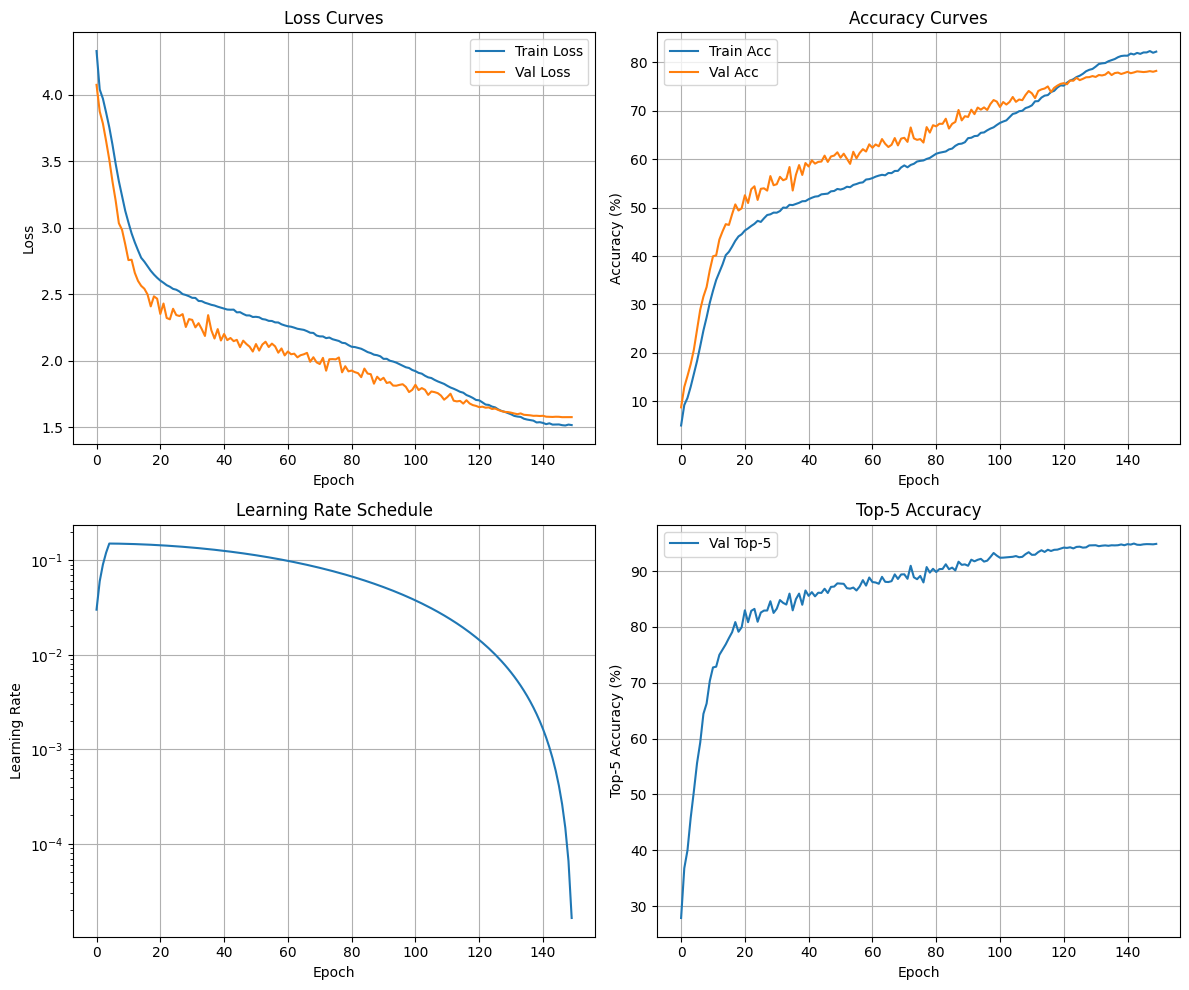


GPU Memory Usage:
Peak allocated: 3.54GB
Current allocated: 0.10GB

Training Summary
Best validation accuracy: 78.23% (Epoch 150)
Final test accuracy: 78.25%
Final test top-5 accuracy: 94.85%

Final model saved to: cifar100_final_model.pth

Training Complete!


In [12]:
# =============================================================================
# Colab Execution
# =============================================================================

if __name__ == "__main__":
    # Check if running in Colab
    try:
        import google.colab
        IN_COLAB = True
        print("Running in Google Colab environment")

        #  Mount Google Drive for saving checkpoints (optional)
        from google.colab import drive
        drive.mount('/content/drive')

    except ImportError:
        IN_COLAB = False
        print("Running in local environment")

    # Execute training pipeline
    print("\n" + "="*60)
    print("CIFAR-100 CNN Training System")
    print("Production-Ready Implementation")
    print("="*60)

    # Train with default configuration
    model, metrics, results = train_cifar100(
        epochs=150,
        batch_size=256,
        learning_rate=0.15,
        mixed_precision=True,
        augmentation='strong'
    )

    print("\n" + "="*60)
    print("Training Complete!")
    print("="*60)